In [8]:
import urllib
import tarfile
import io
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
IMAGES_URI = "https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_images.tar.gz"
LABELS_URI = "https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_labels.tar.gz"

def load_images_from_remote_tar(tar_uri: str) -> list[Image.Image]:
    images = []
    with urllib.request.urlopen(tar_uri) as f:
        tar = tarfile.open(fileobj=io.BytesIO(f.read()))
        for member in tar.getmembers():
            image_data = tar.extractfile(member)
            image = Image.open(image_data)
            images.append(image)
    return images
    
images = load_images_from_remote_tar(IMAGES_URI)
labels = load_images_from_remote_tar(LABELS_URI)
n_images = len(images)
assert n_images == len(labels), f"{len(images)=}, {len(labels)=}"

print(f"Loaded {n_images} images and labels")

Loaded 9 images and labels


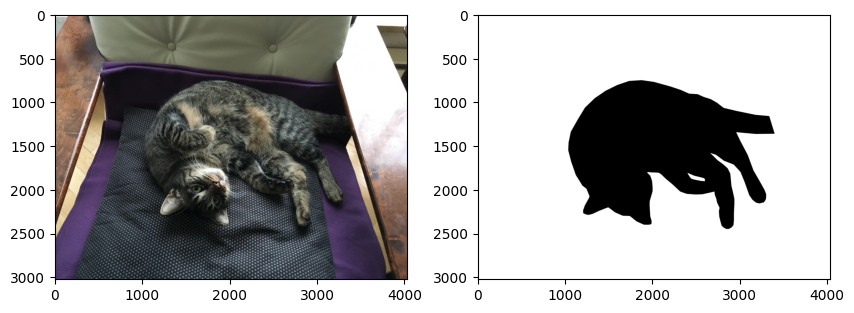

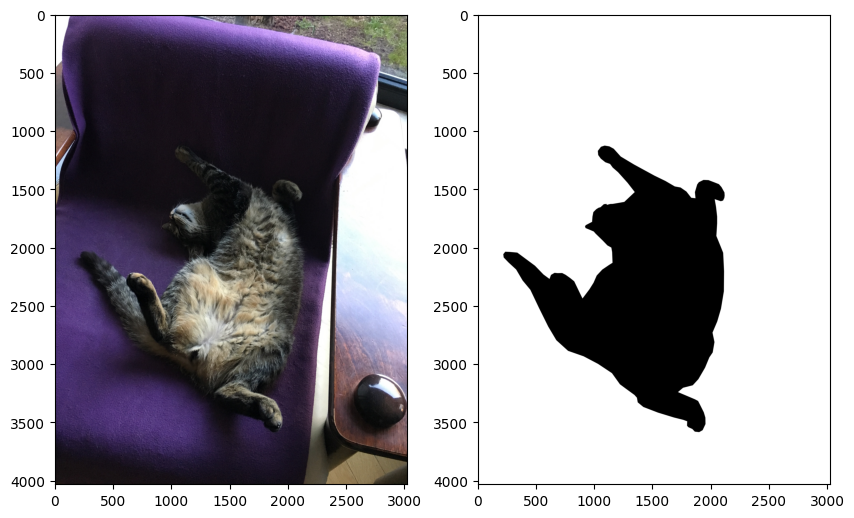

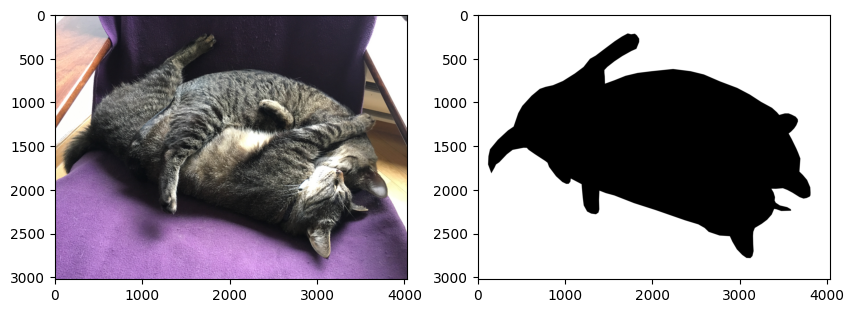

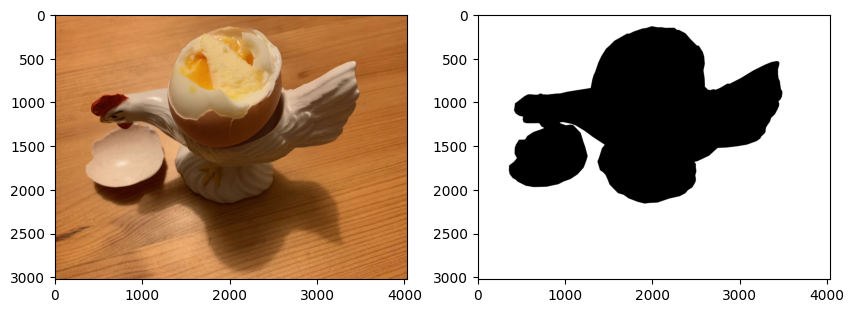

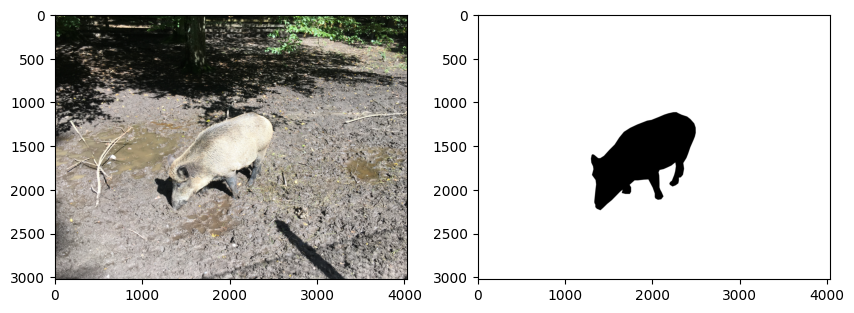

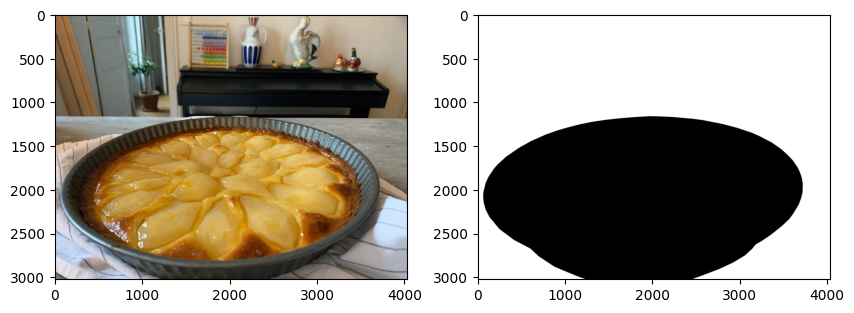

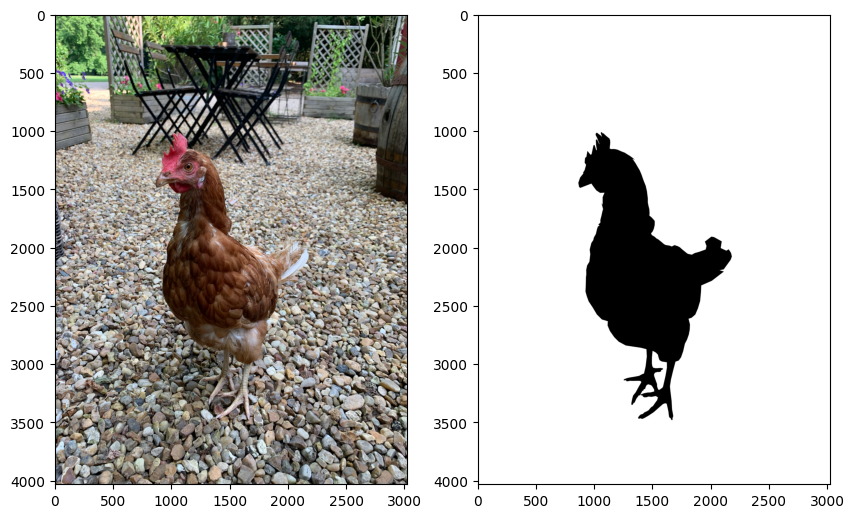

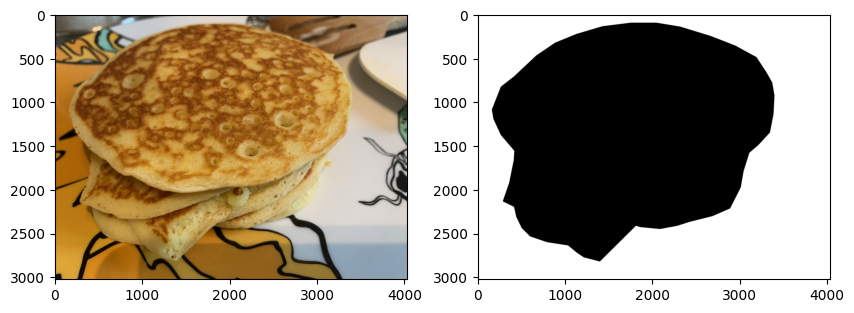

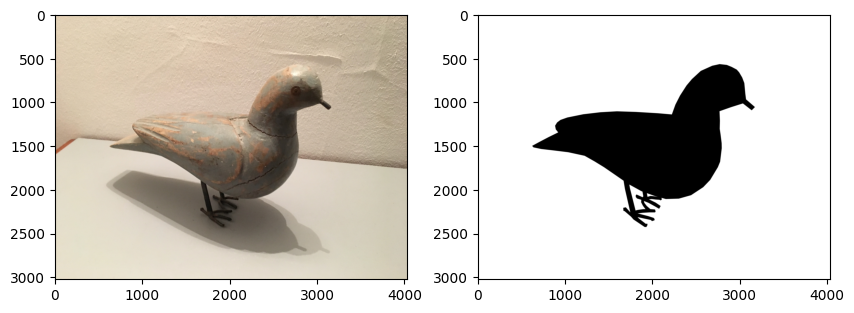

In [12]:
for img, label in zip(images, labels):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(label)
    plt.show()

In [47]:
PATCH_SIZE = 16
IMAGE_SIZE = 768
import torch
import torchvision.transforms.functional as TF


# quantization filter for the given patch size
patch_quant_filter = torch.nn.Conv2d(1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False)
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))

# image resize transform to dimensions divisible by patch size
def resize_transform(
    mask_image: Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))

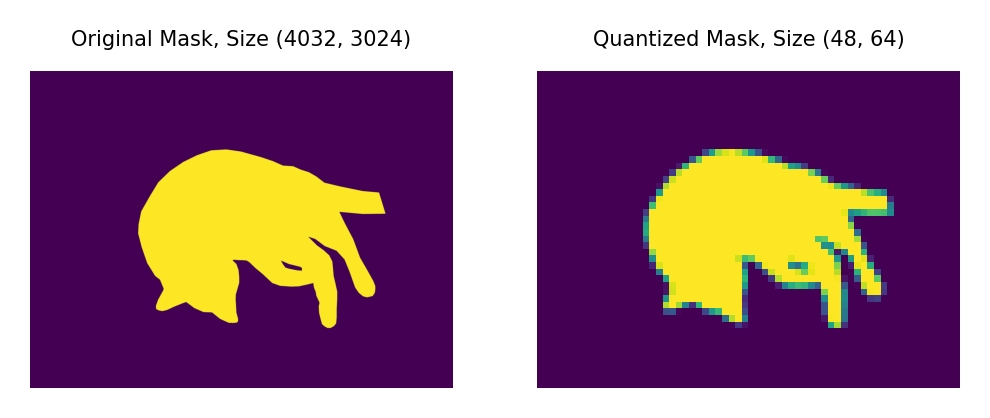

In [48]:

mask_0 = labels[0].split()[-1]
mask_0_resized = resize_transform(mask_0)
with torch.no_grad():
    mask_0_quantized = patch_quant_filter(mask_0_resized).squeeze().detach().cpu()

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(mask_0)
plt.axis('off')
plt.title(f"Original Mask, Size {mask_0.size}", fontsize=5)
plt.subplot(1, 2, 2)
plt.imshow(mask_0_quantized)
plt.axis('off')
plt.title(f"Quantized Mask, Size {tuple(mask_0_quantized.shape)}", fontsize=5)
plt.show()

In [ ]:
from tqdm import tqdm

model = torch.hub.load('facebookresearch/dinov3', 'dinov3_vits16', source='github', weights="https://dinov3.llamameta.net/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoieGJ3dzM4M2o4djlnbmQ0d3NhNHI5c3dkIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTUzNzA0Mjl9fX1dfQ__&Signature=F%7E7LBWyNTy0c4nSnOIjIaGuiUd-AHIgIQzmfwivW28ducAs3kLadd2wj2taoY4K588BkPsp4OItjzYXImnLUGYnPGhzISTR%7EgDgyRhF9yukwsC8uCumExqnzM8sB9KBP0Lracpo3BdCRe9wWgucX21we09jH%7EBuCleOoDVeLZeve9%7EUasCwr-miQhu0vmHirfWdUZ4A%7E%7EHrJ1KU-IxigsCwAq6pfE66tCRIF9wtZaw62RbZi29Frr3AEDrCu3aDJzV6OPemu%7EOX0L-BPliKIh-HZhUI38sDMmvJ2bKKOGArKVuZKuw60rJx0N7FAmiKRjJMfAd-hqK8Qf3vzdj%7EsIQ__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1082201730553524")
# model = torch.hub.load("facebookresearch/dinov3", "dinov3_convnext_tiny", source="github", weights="https://dinov3.llamameta.net/dinov3_convnext_tiny/dinov3_convnext_tiny_pretrain_lvd1689m-21b726bb.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoicDY3OXQ4Ymx1bDI4YjR1bjBicmdkMzN6IiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTU1NTU3NDh9fX1dfQ__&Signature=PboQVwlLVGBtph7kbUax-F8gBjTsSqJ3MTtjpO7MhZ%7EhejB-bc2ZlrGYid%7E14TbzbTIWUEgU7w5sZoChOFJW7O0NFK4xhFqivDwYLTvfUJ-n5yRzoDQp1L8umB3QAUbB3noRbrxQ80VuipJ42zM5KrLJzeANJxtSr9RR51rTvdtfof5OxU4q8wmbBXSHe2NPRNI4f-rzjAPys1VwU3fxpxhH6J3W2mbga8L44-o%7Ems-%7EAkFyheSw6MJtw5Vv9JSW7-oBS1u-fgf0OqHqqZ3LvtAjzgzqaPikzgYQGxcauOuG8QuEv-4NmmZ%7EUhagzGth7CcdrygxA8TCQOd%7E5Fhw9Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1282037712954268")
model.to("mps")

xs = []
ys = []
image_index = []

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

n_layers = 12
# n_layers = 4

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        for i in tqdm(range(n_images), desc="Processing images"):
            # Loading the ground truth
            mask_i = labels[i].split()[-1]
            mask_i_resized = resize_transform(mask_i)
            mask_i_quantized = patch_quant_filter(mask_i_resized).squeeze().view(-1).detach().cpu()
            ys.append(mask_i_quantized)
            # Loading the image data 
            image_i = images[i].convert('RGB')
            image_i_resized = resize_transform(image_i)
            image_i_resized = TF.normalize(image_i_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
            image_i_resized = image_i_resized.unsqueeze(0).to("mps")

            feats = model.get_intermediate_layers(image_i_resized, n=range(n_layers), reshape=True, norm=True)
            dim = feats[-1].shape[1]
            xs.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())

            image_index.append(i * torch.ones(ys[-1].shape))


# Concatenate all lists into torch tensors 
xs = torch.cat(xs)
ys = torch.cat(ys)
image_index = torch.cat(image_index)

# keeping only the patches that have clear positive or negative label
idx = (ys < 0.01) | (ys > 0.99)
xs = xs[idx]
ys = ys[idx]
image_index = image_index[idx]

print("Design matrix of size : ", xs.shape)
print("Label matrix of size : ", ys.shape)

Using cache found in /Users/paan/.cache/torch/hub/facebookresearch_dinov3_main
Processing images:  11%|█         | 1/9 [00:00<00:02,  2.96it/s]

torch.Size([1, 384, 48, 64])


Processing images:  22%|██▏       | 2/9 [00:00<00:01,  4.37it/s]

torch.Size([1, 384, 48, 36])


Processing images:  33%|███▎      | 3/9 [00:00<00:01,  3.97it/s]

torch.Size([1, 384, 48, 64])


Processing images:  44%|████▍     | 4/9 [00:01<00:01,  3.78it/s]

torch.Size([1, 384, 48, 64])


Processing images:  56%|█████▌    | 5/9 [00:01<00:01,  3.71it/s]

torch.Size([1, 384, 48, 64])


Processing images:  67%|██████▋   | 6/9 [00:01<00:00,  3.66it/s]

torch.Size([1, 384, 48, 64])


Processing images:  78%|███████▊  | 7/9 [00:01<00:00,  4.32it/s]

torch.Size([1, 384, 48, 36])


Processing images:  89%|████████▉ | 8/9 [00:02<00:00,  4.03it/s]

torch.Size([1, 384, 48, 64])


Processing images: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]

torch.Size([1, 384, 48, 64])
Design matrix of size :  torch.Size([23604, 384])
Label matrix of size :  torch.Size([23604])


In [50]:
ys.shape, xs.shape

(torch.Size([23604]), torch.Size([23604, 384]))

In [18]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, C=0.1, max_iter=100000, verbose=2).fit(xs.numpy(), (ys > 0).long().numpy())


/Users/paan/miniforge3/envs/dinov2/lib/python3.11/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 and torch.float16 currently.
  warnings.warn(error_message)


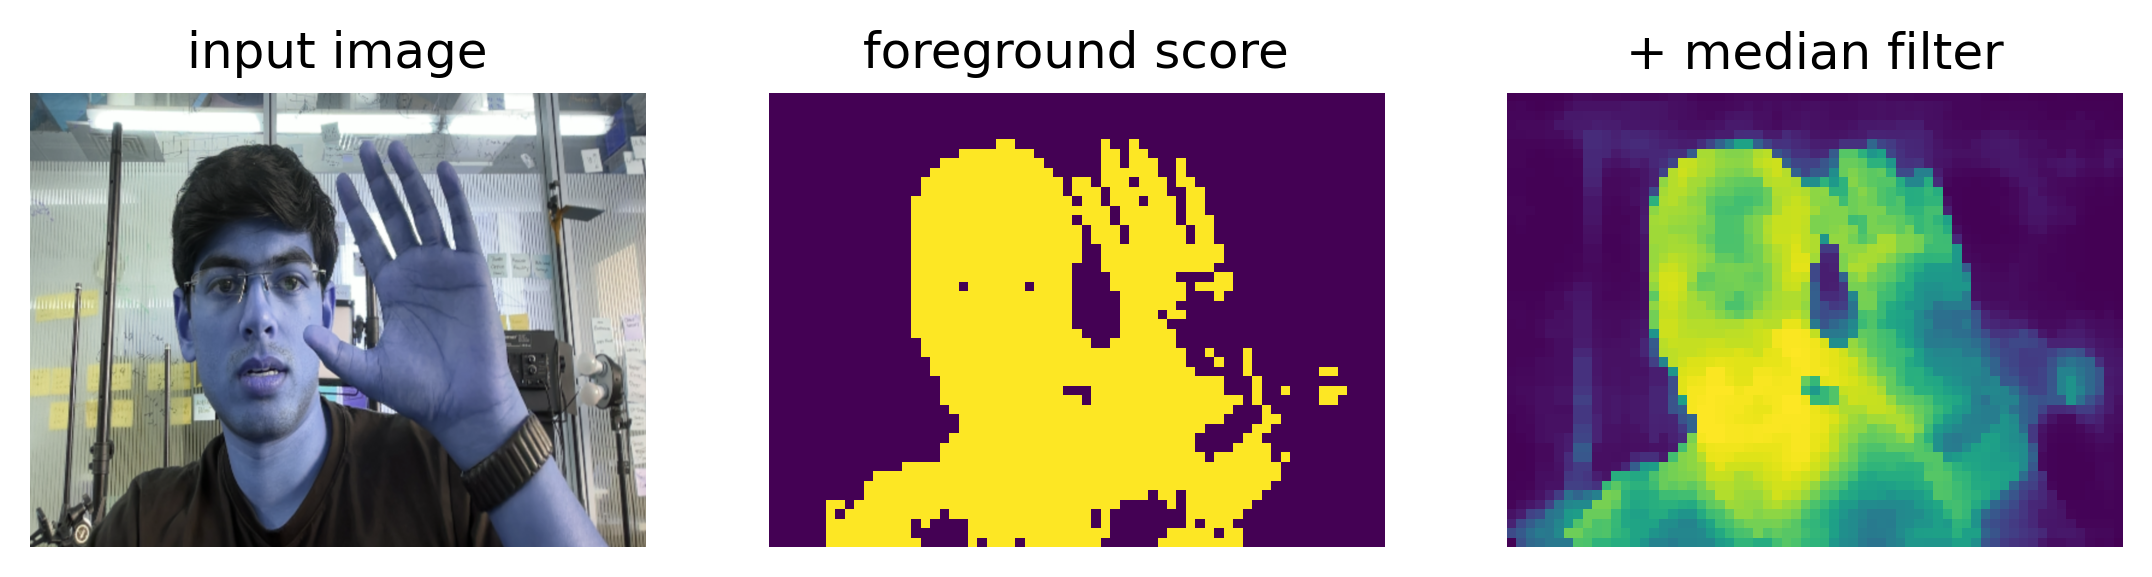

In [34]:
from scipy import signal
# test_image_fpath = "https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/test_image.jpg"
test_image_fpath = '/Users/paan/Downloads/hands2.png'

def load_image_from_url(url: str) -> Image:
    if url.startswith("http"):
        with urllib.request.urlopen(url) as f:
            return Image.open(f).convert("RGB")
    else:
        return Image.open(url).convert("RGB")


test_image = load_image_from_url(test_image_fpath)
test_image_resized = resize_transform(test_image)
test_image_normalized = TF.normalize(test_image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)

with torch.inference_mode():
    with torch.autocast(device_type='mps', dtype=torch.float32):
        feats = model.get_intermediate_layers(test_image_normalized.unsqueeze(0).to("mps"), n=range(n_layers), reshape=True, norm=True)
        x = feats[-1].squeeze().detach().cpu()
        dim = x.shape[0]
        x = x.view(dim, -1).permute(1, 0)

h_patches, w_patches = [int(d / PATCH_SIZE) for d in test_image_resized.shape[1:]]

fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))

plt.figure(figsize=(9, 3), dpi=300)
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(test_image_resized.permute(1, 2, 0))
plt.title('input image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(fg_score > 0.5)
plt.title('foreground score')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(fg_score_mf)
plt.title('+ median filter')
plt.show()

In [35]:
# save this model
import pickle
with open("foreground_segmentation_model.pkl", "wb") as f:
    pickle.dump(clf, f)